In [6]:
import os
import pickle
import numpy as np
from PIL import Image
from skimage.transform import resize
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [7]:
input_dir = 'D:/Téléchargements/archive/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/data'
categories = ['nothing', 'smoke', 'fire']

In [8]:
data = []
labels = []

# Define the target size for resizing
target_size = (100, 100)

for category_idx, category in enumerate(categories):
    category_dir = os.path.join(input_dir, category)
    if os.path.isdir(category_dir):
        for file in os.listdir(category_dir):
            img_path = os.path.join(category_dir, file)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Convert to RGB
                    img = np.array(img)  # Convert to NumPy array
                    img = resize(img, target_size, anti_aliasing=True)  # Resize
                    data.append(img.flatten())
                    labels.append(category_idx)  # Use category index as label
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

data = np.asarray(data)
labels = np.asarray(labels)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)


In [10]:
# Normalisation des données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [11]:
# Use a Decision Tree Classifier
classifier = DecisionTreeClassifier()

# Define the parameters to be tuned via GridSearchCV
parameters = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(classifier, parameters,cv=5 ,n_jobs=3)

grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=3,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [12]:
# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score de validation croisée:", grid_search.best_score_)

Meilleurs paramètres: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleur score de validation croisée: 0.8632910526796875


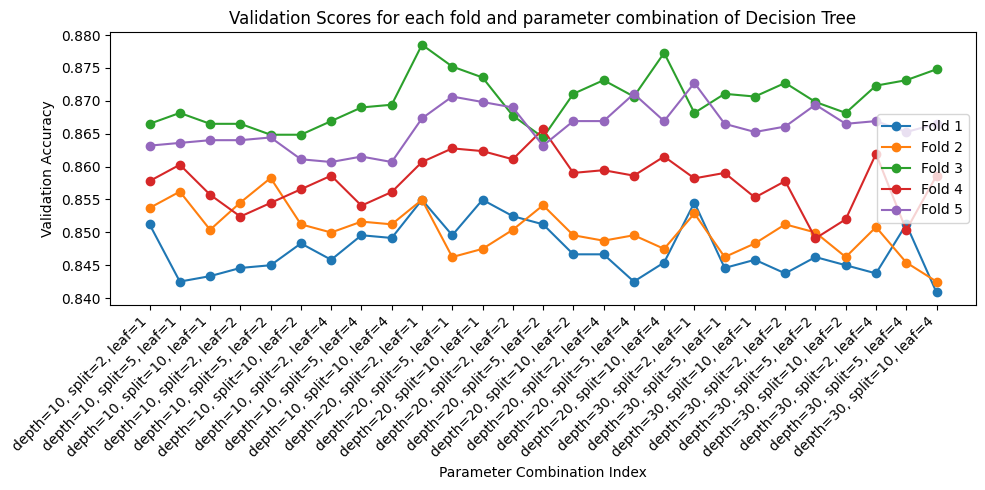

In [17]:
scores_fold = grid_search.cv_results_['split0_test_score']
params_dt = grid_search.cv_results_['params']

# Préparer les listes pour les axes x et y
x_values_dt = [i for i in range(len(params_dt))]
labels_dt = [f"depth={p['max_depth']}, split={p['min_samples_split']}, leaf={p['min_samples_leaf']}" for p in params_dt]

# Tracer les scores de validation pour chaque fold
plt.figure(figsize=(10, 5))

# Boucle pour tracer chaque ensemble de scores par fold
for i in range(5):
    fold_scores = grid_search.cv_results_[f'split{i}_test_score']
    plt.plot(x_values_dt, fold_scores, marker='o', linestyle='-', label=f'Fold {i+1}')

plt.title('Validation Scores for each fold and parameter combination of Decision Tree')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Validation Accuracy')
plt.xticks(x_values_dt, labels_dt, rotation=45, ha="right")
plt.legend()
plt.tight_layout()  # Ajuster automatiquement pour éviter le chevauchement
plt.show()

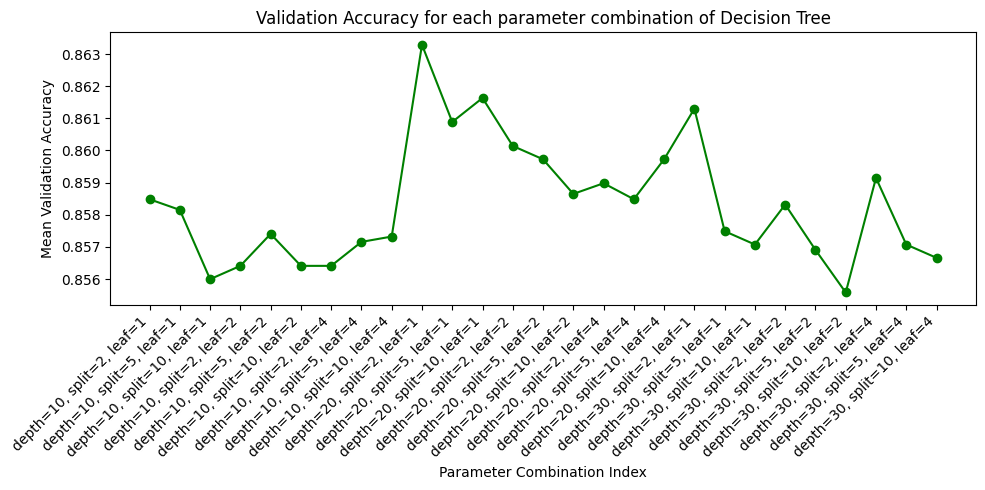

In [15]:
import matplotlib.pyplot as plt

# Extraire les scores de validation moyens et les paramètres correspondants
mean_scores_dt = grid_search.cv_results_['mean_test_score']
params_dt = grid_search.cv_results_['params']

# Préparer les listes pour les axes x et y
x_values_dt = [i for i in range(len(params_dt))]
labels_dt = [f"depth={p['max_depth']}, split={p['min_samples_split']}, leaf={p['min_samples_leaf']}" for p in params_dt]

# Tracer les scores de validation en fonction des paramètres pour le Decision Tree
plt.figure(figsize=(10, 5))
plt.plot(x_values_dt, mean_scores_dt, marker='o', linestyle='-', color='g')  # color green pour différencier
plt.title('Validation Accuracy for each parameter combination of Decision Tree')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean Validation Accuracy')
plt.xticks(x_values_dt, labels_dt, rotation=45, ha="right")
plt.tight_layout()  # Ajuster automatiquement pour éviter le chevauchement
plt.show()

In [19]:
# Utilisation des meilleurs paramètres pour créer le modèle final
best_classifier = grid_search.best_estimator_
y_prediction = best_classifier.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, y_prediction)

In [20]:
# Affichage des résultats
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.8620689655172413


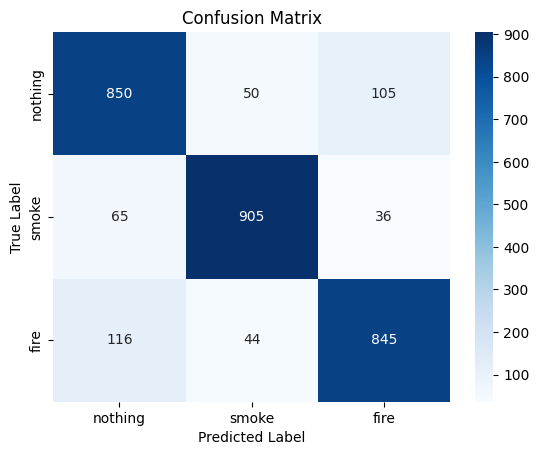

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_prediction)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Affichage du rapport de classification
from sklearn.metrics import classification_report  # Import the classification_report function
classification_rep = classification_report(y_test, y_prediction)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1005
           1       0.91      0.90      0.90      1006
           2       0.86      0.84      0.85      1005

    accuracy                           0.86      3016
   macro avg       0.86      0.86      0.86      3016
weighted avg       0.86      0.86      0.86      3016



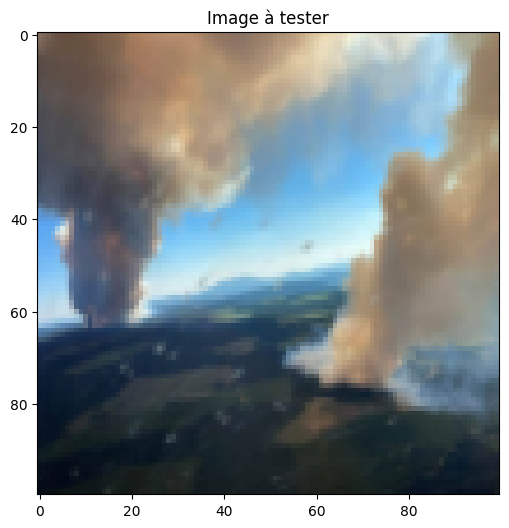

Catégorie prédite: nothing


In [24]:
new_image_path = 'D:/Téléchargements/this-handout-photo-cou.jpg'

try:
    with Image.open(new_image_path) as img:
        img = img.convert('RGB')  # Convertir en RGB
        img = np.array(img)  # Convertir en tableau NumPy
        img_resized = resize(img, target_size, anti_aliasing=True)  # Redimensionner
        
        # Afficher l'image
        plt.figure(figsize=(6, 6))
        plt.imshow(img_resized)
        plt.title('Image à tester')
        plt.show()
        
        # Aplatir l'image si votre modèle attend des données aplaties
        img_flattened = img_resized.flatten().reshape(1, -1)
        
        # Utilisation du modèle pour faire une prédiction
        predicted_category_index = best_classifier.predict(img_flattened)[0]

        
        # Afficher la catégorie prédite
        print(f'Catégorie prédite: {categories[predicted_category_index]}')
        
except Exception as e:
    print(f"Erreur lors de la lecture de l'image {new_image_path}: {e}")

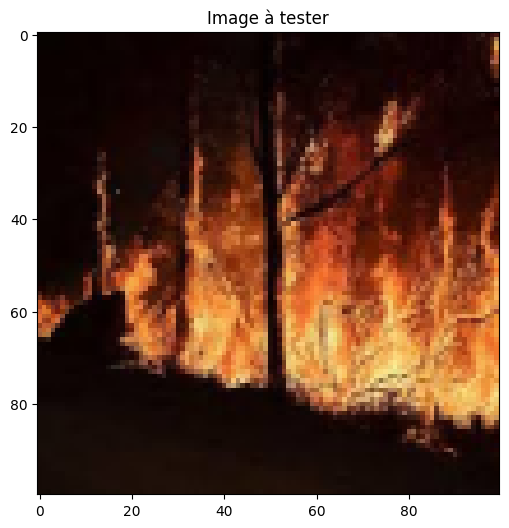

Catégorie prédite: fire


In [25]:
new_image_path = 'D:/Téléchargements/images (4).jpg'

try:
    with Image.open(new_image_path) as img:
        img = img.convert('RGB')  # Convertir en RGB
        img = np.array(img)  # Convertir en tableau NumPy
        img_resized = resize(img, target_size, anti_aliasing=True)  # Redimensionner
        
        # Afficher l'image
        plt.figure(figsize=(6, 6))
        plt.imshow(img_resized)
        plt.title('Image à tester')
        plt.show()
        
        # Aplatir l'image si votre modèle attend des données aplaties
        img_flattened = img_resized.flatten().reshape(1, -1)
        
        # Utilisation du modèle pour faire une prédiction
        predicted_category_index = best_classifier.predict(img_flattened)[0]

        
        # Afficher la catégorie prédite
        print(f'Catégorie prédite: {categories[predicted_category_index]}')
        
except Exception as e:
    print(f"Erreur lors de la lecture de l'image {new_image_path}: {e}")

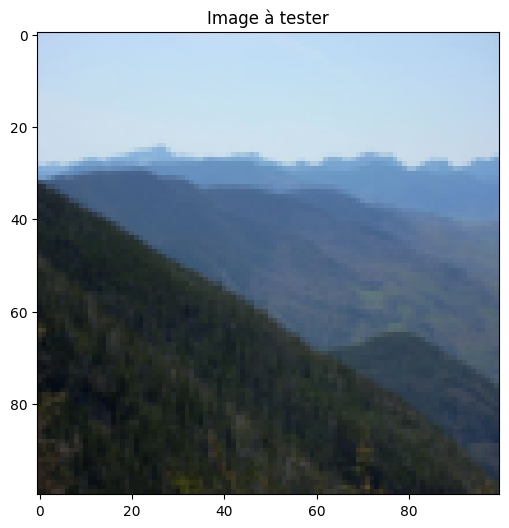

Catégorie prédite: nothing


In [26]:
new_image_path = 'D:/Téléchargements/ff.jpg'

try:
    with Image.open(new_image_path) as img:
        img = img.convert('RGB')  # Convertir en RGB
        img = np.array(img)  # Convertir en tableau NumPy
        img_resized = resize(img, target_size, anti_aliasing=True)  # Redimensionner
        
        # Afficher l'image
        plt.figure(figsize=(6, 6))
        plt.imshow(img_resized)
        plt.title('Image à tester')
        plt.show()
        
        # Aplatir l'image si votre modèle attend des données aplaties
        img_flattened = img_resized.flatten().reshape(1, -1)
        
        # Utilisation du modèle pour faire une prédiction
        predicted_category_index = best_classifier.predict(img_flattened)[0]

        
        # Afficher la catégorie prédite
        print(f'Catégorie prédite: {categories[predicted_category_index]}')
        
except Exception as e:
    print(f"Erreur lors de la lecture de l'image {new_image_path}: {e}")

In [27]:
pickle.dump(best_classifier, open('C:/Users/chatt/Desktop/DecisionTreeClassifier.p', 'wb'))